In [ ]:
!pip install -q tensorflow pandas matplotlib scikit-learn

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define paths
csv_path = "/content/drive/MyDrive/TB_Project/radiologist_feedback.csv"
IMAGE_DIR = "/content/drive/MyDrive/TB_Project/feedbackimages/"

In [ ]:
# Load CSV with error handling
try:
    df = pd.read_csv(csv_path, encoding="utf-8")
except UnicodeDecodeError:
    df = pd.read_csv(csv_path, encoding="latin1")

In [ ]:
# Clean text columns
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

print("Successfully read CSV!")
print(df.head())

Successfully read CSV!
             Timestamp Image Filename  AI Predicted TB Severity  \
0  2025-03-18 11:25:55         30.jpg                     33.99   
1  2025-03-18 11:43:25         65.jpg                     84.77   
2  2025-03-18 11:42:55         64.jpg                     40.26   
3  2025-03-18 11:37:25         53.jpg                      2.05   
4  2025-03-18 11:33:25         45.jpg                      1.06   

   Radiologist Severity False Positive False Negative  
0                     1             No             No  
1                     3             No             No  
2                     1             No             No  
3                     0             No             No  
4                     0             No             No  


<ipython-input-6-57f958b8331b>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [ ]:
# Remove duplicates & empty rows
df = df.dropna().drop_duplicates()
print(f"📉 Total Rows After Cleanup: {len(df)}")

📉 Total Rows After Cleanup: 103


In [ ]:
# Ensure Radiologist Severity is numerical
df["Radiologist Severity"] = df["Radiologist Severity"].astype(int)

# Generate full image paths
df["Image Path"] = IMAGE_DIR + df["Image Filename"].astype(str)

In [ ]:
# Extract filenames and labels
image_paths = df["Image Path"].tolist()
severity_labels = df["Radiologist Severity"].values

# Convert severity to binary TB classification (0 = Normal, 1 = TB present)
tb_labels = (severity_labels > 0).astype(int)

# One-hot encode severity labels (4 classes: 0,1,2,3)
y_severity = to_categorical(severity_labels, num_classes=4)

In [ ]:
# Image size
IMG_SIZE = (128, 128)

# Function to preprocess images
def preprocess_image(image_path):
    if os.path.exists(image_path):
        img = load_img(image_path, target_size=IMG_SIZE, color_mode="rgb")
        img_array = img_to_array(img) / 255.0  # Normalize
        return img_array
    else:
        print(f"⚠️ Warning: Image {image_path} not found!")
        return np.zeros((128, 128, 3))  # Placeholder black image

In [ ]:
# Convert images & labels into arrays
X = np.array([preprocess_image(path) for path in image_paths])
y_tb = np.array(tb_labels)

# Split Dataset (80% Train, 20% Validation)
X_train, X_val, y_train_tb, y_val_tb, y_train_severity, y_val_severity = train_test_split(
    X, y_tb, y_severity, test_size=0.2, random_state=42
)

print(f"Train Data: {X_train.shape}, Validation Data: {X_val.shape}")

Train Data: (82, 128, 128, 3), Validation Data: (21, 128, 128, 3)


In [ ]:
# Define Input Layer
input_layer = Input(shape=(128, 128, 3))

# Feature Extraction (CNN)
x = Conv2D(32, (3,3), activation='relu')(input_layer)
x = MaxPooling2D(2,2)(x)

x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(2,2)(x)

x = Conv2D(128, (3,3), activation='relu')(x)
x = MaxPooling2D(2,2)(x)

x = Conv2D(256, (3,3), activation='relu')(x)
x = MaxPooling2D(2,2)(x)

x = Flatten()(x)

# Shared Dense Layers
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

# Output 1: TB Classification (0 or 1)
tb_classification = Dense(1, activation="sigmoid", name="TB_Classification")(x)

# Output 2: Severity Score (Categorical 4 Classes)
severity_score = Dense(4, activation="softmax", name="Severity_Score")(x)

# Create Model
model = Model(inputs=input_layer, outputs=[tb_classification, severity_score])

# Compile Model
optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)

model.compile(
    optimizer=optimizer,
    loss={
        "TB_Classification": "binary_crossentropy",
        "Severity_Score": "categorical_crossentropy"
    },
    metrics={
        "TB_Classification": "accuracy",
        "Severity_Score": "accuracy"
    }
)

# Print Model Summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 126, 126, 32)   │            896 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 63, 63, 32)     │              0 │ conv2d_9[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 61, 61, 64)     │         18,496 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 30, 30, 64)     │              0 │ conv2d_10[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 28, 28, 128)    │         73,856 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 14, 14, 128)    │              0 │ conv2d_11[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 12, 12, 256)    │        295,168 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 6, 6, 256)      │              0 │ conv2d_12[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 9216)           │              0 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 128)            │      1,179,776 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 128)            │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 64)             │          8,256 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 64)             │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ TB_Classification (Dense) │ (None, 1)              │             65 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Severity_Score (Dense)    │ (None, 4)              │            260 │ dropout_7[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,576,773 (6.01 MB)

 Trainable params: 1,576,773 (6.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Learning Rate Scheduler
lr_decay = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train Model
history = model.fit(
    X_train, [y_train_tb, y_train_severity],  # Fixed labels here
    validation_data=(X_val, [y_val_tb, y_val_severity]),
    epochs=50,
    batch_size=8,
    callbacks=[lr_decay,early_stop]
)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 415ms/step - Severity_Score_accuracy: 0.3816 - Severity_Score_loss: 1.3753 - TB_Classification_accuracy: 0.7196 - TB_Classification_loss: 0.6146 - loss: 1.9904 - val_Severity_Score_accuracy: 0.3333 - val_Severity_Score_loss: 1.3773 - val_TB_Classification_accuracy: 0.9048 - val_TB_Classification_loss: 0.4544 - val_loss: 1.8211 - learning_rate: 1.5625e-06
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 291ms/step - Severity_Score_accuracy: 0.2053 - Severity_Score_loss: 1.4151 - TB_Classification_accuracy: 0.7421 - TB_Classification_loss: 0.5884 - loss: 2.0063 - val_Severity_Score_accuracy: 0.3333 - val_Severity_Score_loss: 1.3773 - val_TB_Classification_accuracy: 0.9048 - val_TB_Classification_loss: 0.4543 - val_loss: 1.8209 - learning_rate: 1.5625e-06
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step - Severity_Score_accuracy: 0.1886 - Severity_Score_loss: 1.4200 - TB_Classification_accuracy: 0.7127 - TB_Classification_loss: 0.5767 - loss: 1.9955 - v

In [ ]:
# Evaluate Model
val_loss, val_tb_loss, val_severity_loss, val_tb_acc, val_severity_acc = model.evaluate(
    X_val, [y_val_tb, y_val_severity]
)

print(f"✅ Validation TB Classification Accuracy: {val_tb_acc * 100:.2f}%")
print(f"✅ Validation Severity Score Accuracy: {val_severity_acc * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - Severity_Score_accuracy: 0.3333 - Severity_Score_loss: 1.3776 - TB_Classification_accuracy: 0.9048 - TB_Classification_loss: 0.4424 - loss: 1.8200
✅ Validation TB Classification Accuracy: 33.33%
✅ Validation Severity Score Accuracy: 90.48%


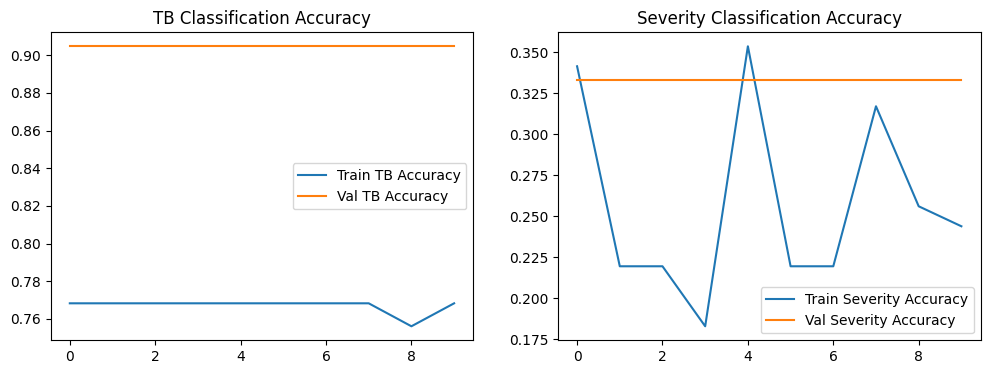

In [ ]:
# Plot Training Performance
plt.figure(figsize=(12, 4))

# TB Classification Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history["TB_Classification_accuracy"], label="Train TB Accuracy")
plt.plot(history.history["val_TB_Classification_accuracy"], label="Val TB Accuracy")
plt.legend()
plt.title("TB Classification Accuracy")

# Severity Score Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history["Severity_Score_accuracy"], label="Train Severity Accuracy")
plt.plot(history.history["val_Severity_Score_accuracy"], label="Val Severity Accuracy")
plt.legend()
plt.title("Severity Classification Accuracy")

plt.show()

In [ ]:
model.save("/content/drive/MyDrive/TB_Project/tb_severity_model.keras")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Define model path
model_path = "/content/drive/MyDrive/TB_Project/tb_detection_model.keras"

# Check if a previously trained model exists
if os.path.exists(model_path):
    print("🔄 Loading existing model for retraining...")
    model = load_model(model_path)
else:
    print("🆕 No existing model found. Training from scratch...")

    # Define Input Layer
    input_layer = Input(shape=(128, 128, 3))

    # Feature Extraction (CNN)
    x = Conv2D(32, (3,3), activation='relu')(input_layer)
    x = MaxPooling2D(2,2)(x)

    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D(2,2)(x)

    x = Conv2D(128, (3,3), activation='relu')(x)
    x = MaxPooling2D(2,2)(x)

    x = Conv2D(256, (3,3), activation='relu')(x)
    x = MaxPooling2D(2,2)(x)

    x = Flatten()(x)

    # Shared Dense Layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output 1: TB Classification (0 or 1)
    tb_classification = Dense(1, activation="sigmoid", name="TB_Classification")(x)

    # Output 2: Severity Score (Categorical 4 Classes)
    severity_score = Dense(4, activation="softmax", name="Severity_Score")(x)

    # Create Model
    model = Model(inputs=input_layer, outputs=[tb_classification, severity_score])

    # Compile Model
    optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)

    model.compile(
        optimizer=optimizer,
        loss={
            "TB_Classification": "binary_crossentropy",
            "Severity_Score": "categorical_crossentropy"
        },
        metrics={
            "TB_Classification": "accuracy",
            "Severity_Score": "accuracy"
        }
    )

    print("✅ New model created!")

# Train Model (Continue training on existing model)
history = model.fit(
    X_train, [y_train_tb, y_train_severity],
    validation_data=(X_val, [y_val_tb, y_val_severity]),
    epochs=50,
    batch_size=8,
    callbacks=[lr_decay, early_stop]
)

# Save the retrained model
model.save(model_path)
print(f"✅ Retrained model saved at: {model_path}")
